In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
from scipy.spatial import KDTree
import pygsheets
import ast
from collections import Counter, defaultdict
import time
import pickle
from scipy.spatial.distance import cdist
import networkx as nx
import random
from itertools import combinations
import scipy.sparse as sp

vol_graphene =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
vol = cv('gs://zheng_mouse_hippocampus_production/v2/seg_m195',parallel=True, progress=False, use_https=True)
client = CAVEclient('zheng_ca3')


In [23]:
# load data from spreadsheet
gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('CA3_cells')
mf_sheet = sheet.worksheet('title','mossy_fibers')
pyr_sheet = sheet.worksheet('title','pyramidal_cells')
mf_df = mf_sheet.get_as_df()
mf_df = mf_df[mf_df['type'] == 'mossy fiber']
mf_df.drop(columns=['type','segid_195','segid'],inplace=True)
mf_df = mf_df[mf_df['supervoxel'] != 0]
pc_df = pyr_sheet.get_as_df()

sheet3 = gc.open('CA3 proofreading 2')
mf_sheet2 = sheet3.worksheet('title','16.extra_MFs')
mf_df2 = mf_sheet2.get_as_df(start='A5')
mf_df2 = mf_df2[mf_df2['type'] == 'MF']
mf_df2.drop(columns=['updated_segids', 'pre_pt_root_id','post_pt_root_id','syn_count','pre_pt_position','type','status','Proofreader','Comments','ZZ Comments'],inplace=True)
mf_df2 = mf_df2[mf_df2['pre_pt_supervoxel'] != 0]

sheet2 = gc.open('all_pyramidal_cells')
mfpc_sheet = sheet2.worksheet('title','MF-pyr')
mfpc_df = mfpc_sheet.get_as_df(start='A4')
thorny_nuc_ids = mfpc_df['segid (Nuclei table segID)'].values
thorny_df = pc_df[pc_df['nucleus_segids'].isin(thorny_nuc_ids)]


In [24]:
# load MF latest roots from SV

mf_sv1 = mf_df['supervoxel'].values
mf_sv2 = mf_df2['pre_pt_supervoxel'].values
mf_sv = np.concatenate((mf_sv1, mf_sv2))
mf_latest_roots = client.chunkedgraph.get_roots(mf_sv)

print(len(mf_latest_roots))
print(len(list(set(mf_latest_roots))))

57163
55904


In [79]:
# get latest PC roots

# 1800 pyr cells
nuclei_coord_in_vol = pc_df[['x','y','z']].to_numpy()
nuclei_coord_in_vol = np.array([list(row) for row in nuclei_coord_in_vol if not np.array_equal(row, np.array(['', '', '']))])

# 600 pyr cells
#nuclei_coord_in_vol = mfpc_df[['x','y','z']].to_numpy()

latest_roots_PC = []
print('Getting latest roots for PC...')  
pc_coords = []
cell_ids_scatter = vol_graphene.scattered_points(nuclei_coord_in_vol)
for i in range(0, len(nuclei_coord_in_vol)):
    if i % 100 == 0:
        print(i,'/',len(nuclei_coord_in_vol))
    cell_ID = [cell_ids_scatter.get(tuple(nuclei_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
        pc_coords.append(nuclei_coord_in_vol[i,:]-[150,0,0])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
        pc_coords.append(nuclei_coord_in_vol[i,:]+[0,150,0])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
        pc_coords.append(nuclei_coord_in_vol[i,:]-[0,150,0])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        pc_coords.append(nuclei_coord_in_vol[i,:])
        if client.chunkedgraph.is_latest_roots(cell_ID[0]):
            latest_roots_PC.append(cell_ID[0])
        else:
            latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))
            
#pyr_root_to_proximodistal_dist = dict(zip(latest_roots_PC, mfpc_df['curve_distance'].values))


Getting latest roots for PC...


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1815/1815 [00:22<00:00, 80.36it/s]


0 / 1815
100 / 1815
200 / 1815
300 / 1815
400 / 1815
500 / 1815
600 / 1815
700 / 1815
800 / 1815
900 / 1815
1000 / 1815
1100 / 1815
1200 / 1815
1300 / 1815
1400 / 1815
1500 / 1815
1600 / 1815
1700 / 1815
1800 / 1815


In [55]:
# MF-PC IDs where MF synapses onto thorns or shaft
# Some rows of thorn and shaft synapses are missing. rescue them. 

sheet4 = gc.open('common_inputs')
ci_sheet = sheet4.worksheet('title','MF_Pyr_ci')
ci_df = ci_sheet.get_as_df()
ci_df_thorn = ci_df[ci_df['type'] == 'thorn']
mf_syn_to_thorn = ci_df_thorn['MF'].values
pyr_syn_on_thorn = ci_df_thorn['Pyr'].values

ci_df_shaft = ci_df[ci_df['type'] == 'shaft']
mf_syn_to_shaft = ci_df_shaft['MF'].values
pyr_syn_on_shaft = ci_df_shaft['Pyr'].values

sv_mt1 = ci_df_thorn['MF_supervoxel'].values
sv_ms1 = ci_df_shaft['MF_supervoxel'].values
sv_pt1 = ci_df_thorn['Pyr_supervoxel'].values
sv_ps1 = ci_df_shaft['Pyr_supervoxel'].values

not_mf_sv = ci_df.loc[ci_df['type'] == 'not_MF', 'MF_supervoxel'].values
not_mf_ids = client.chunkedgraph.get_roots(not_mf_sv)

sheet4 = gc.open('common_inputs')
ci_sheet = sheet4.worksheet('title','MF_Pyr_ci_all')
ci_df = ci_sheet.get_as_df()
ci_df_thorn = ci_df[ci_df['type'] == 'thorn']
mf_syn_to_thorn = ci_df_thorn['MF'].values
pyr_syn_on_thorn = ci_df_thorn['Pyr'].values

ci_df_shaft = ci_df[ci_df['type'] == 'shaft']
mf_syn_to_shaft = ci_df_shaft['MF'].values
pyr_syn_on_shaft = ci_df_shaft['Pyr'].values

sv_mt2 = ci_df_thorn['MF_supervoxel'].values
sv_ms2 = ci_df_shaft['MF_supervoxel'].values
sv_pt2 = ci_df_thorn['Pyr_supervoxel'].values
sv_ps2 = ci_df_shaft['Pyr_supervoxel'].values

sv_t_pair1 = list(zip(sv_mt1, sv_pt1))
sv_s_pair1 = list(zip(sv_ms1, sv_ps1))
sv_t_pair2 = list(zip(sv_mt2, sv_pt2))
sv_s_pair2 = list(zip(sv_ms2, sv_ps2))

missed_t = [t for t in sv_t_pair1 if t not in sv_t_pair2]
missed_s = [s for s in sv_s_pair1 if s not in sv_s_pair2]

missed_sv_mt = [t[0] for t in missed_t]
missed_sv_pt = [t[1] for t in missed_t]
missed_sv_ms = [t[0] for t in missed_s]
missed_sv_ps = [t[1] for t in missed_s]

mf_thorn_latest_missing = (client.chunkedgraph.get_roots(missed_sv_mt))
pyr_thorn_latest_missing = (client.chunkedgraph.get_roots(missed_sv_pt))
mf_shaft_latest_missing = (client.chunkedgraph.get_roots(missed_sv_ms))
pyr_shaft_latest_missing = (client.chunkedgraph.get_roots(missed_sv_ps))

In [63]:
# MF-PC IDs where MF synapses onto thorns or shaft

sheet4 = gc.open('common_inputs')
ci_sheet = sheet4.worksheet('title','MF_Pyr_ci_all')
ci_df = ci_sheet.get_as_df()
ci_df_thorn = ci_df[ci_df['type'] == 'thorn']
mf_syn_to_thorn = ci_df_thorn['MF'].values
pyr_syn_on_thorn = ci_df_thorn['Pyr'].values

ci_df_shaft = ci_df[ci_df['type'] == 'shaft']
mf_syn_to_shaft = ci_df_shaft['MF'].values
pyr_syn_on_shaft = ci_df_shaft['Pyr'].values

#sheet5  = sheet4.worksheet('title','Sheet1')
#ci_df_w_sv = sheet5.get_as_df()
sv_temp1 = []
sv_temp2 = []
for i in range(len(mf_syn_to_thorn)):
    sv_temp1.append(ci_df.loc[ci_df['MF'] == mf_syn_to_thorn[i], 'MF_supervoxel'].values[0])
    sv_temp2.append(ci_df.loc[ci_df['Pyr'] == pyr_syn_on_thorn[i], 'Pyr_supervoxel'].values[0])
mf_syn_to_thorn_latest=(client.chunkedgraph.get_roots(sv_temp1))
pyr_syn_on_thorn_latest=(client.chunkedgraph.get_roots(sv_temp2))

sv_temp3 = []
sv_temp4 = []
for i in range(len(mf_syn_to_shaft)):
    sv_temp3.append(ci_df.loc[ci_df['MF'] == mf_syn_to_shaft[i], 'MF_supervoxel'].values[0])
    sv_temp4.append(ci_df.loc[ci_df['Pyr'] == pyr_syn_on_shaft[i], 'Pyr_supervoxel'].values[0])
mf_syn_to_shaft_latest=(client.chunkedgraph.get_roots(sv_temp3))
pyr_syn_on_shaft_latest=(client.chunkedgraph.get_roots(sv_temp4))


In [77]:
mf_syn_to_thorn = np.append(mf_syn_to_thorn_latest, mf_thorn_latest_missing)
mf_syn_to_shaft = np.append(mf_syn_to_shaft_latest, mf_shaft_latest_missing)
pyr_syn_on_thorn = np.append(pyr_syn_on_thorn_latest, pyr_thorn_latest_missing)
pyr_syn_on_shaft = np.append(pyr_syn_on_shaft_latest, pyr_shaft_latest_missing)

mf_pyr_syn_on_thorn = list(zip(mf_syn_to_thorn, pyr_syn_on_thorn))
mf_pyr_syn_on_shaft = list(zip(mf_syn_to_shaft, pyr_syn_on_shaft))

print(len(mf_pyr_syn_on_shaft))
print(len(mf_pyr_syn_on_thorn))
mf_pyr_thorn_shaft_combined = mf_pyr_syn_on_thorn + mf_pyr_syn_on_shaft
print(len(mf_pyr_thorn_shaft_combined))


897
3270
4167


In [78]:
print(len(mf_syn_to_thorn))
print(len(mf_syn_to_shaft))
print(len(pyr_syn_on_shaft))

3270
897
897


In [86]:
diff_id = [t for t in mf_syn_to_shaft if t in mf_latest_roots]
print(len(diff_id))

897


In [31]:
# add sv columns to MF_Pyr_ci sheet

'''
mf_sv_column = []
pyr_sv_column = []
for i in range(len(ci_df)):
    mf_sv_column.append([str(ci_df_w_sv.loc[ ci_df_w_sv['mf_segid'] == ci_df['MF'].values[i], 'mf_supervoxel'].iloc[0])]) 
    pyr1_sv = ci_df_w_sv.loc[(ci_df_w_sv['pyr1_segid'] == ci_df['Pyr'].values[i]), 'pyr1_supervoxel']
    if len(pyr1_sv) >0:
        pyr_sv_column.append([str(pyr1_sv.iloc[0])])
    else:
        pyr2_sv = ci_df_w_sv.loc[(ci_df_w_sv['pyr2_segid'] == ci_df['Pyr'].values[i]), 'pyr2_supervoxel']
        pyr_sv_column.append([str(pyr2_sv.iloc[0])])
'''
#ci_sheet.update_values('J2', mf_sv_column)
#ci_sheet.update_values('K2', pyr_sv_column)

In [35]:
'''
mf_syn_to_thorn = mf_syn_to_thorn_latest
mf_syn_to_shaft = mf_syn_to_shaft_latest

for i in range(len(pyr_syn_on_thorn)):
    if i % 100 == 0:
        print(i)
    if client.chunkedgraph.is_latest_roots(pyr_syn_on_thorn[i]):
        continue
    else:
        pyr_syn_on_thorn[i] =client.chunkedgraph.suggest_latest_roots(pyr_syn_on_thorn[i])
mf_pyr_syn_on_thorn = list(zip(mf_syn_to_thorn, pyr_syn_on_thorn))


for i in range(len(pyr_syn_on_shaft)):
    if i % 100 == 0:
        print(i)
    if client.chunkedgraph.is_latest_roots(pyr_syn_on_shaft[i]):
        continue
    else:
        pyr_syn_on_shaft[i] =client.chunkedgraph.suggest_latest_roots(pyr_syn_on_shaft[i])
mf_pyr_syn_on_shaft = list(zip(mf_syn_to_shaft, pyr_syn_on_shaft))

print(len(mf_pyr_syn_on_shaft))
print(len(mf_pyr_syn_on_thorn))
mf_pyr_thorn_shaft_combined = mf_pyr_syn_on_thorn + mf_pyr_syn_on_shaft
print(len(mf_pyr_thorn_shaft_combined))
'''
# check if ids in pyr_syn_on_thorn are latest:
'''
not_latest_temp = []
for index, elem in enumerate(pyr_syn_on_thorn):
    if elem not in latest_roots_PC:
        not_latest_temp.append(elem)
        

if len(not_latest_temp) == 0:
    print("every pyr ID is up to date")
else:
    print("Some pyr IDs are old roots")
'''

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
0
100
200
300
400
500
600
700
800
837
3023
3860


'\nnot_latest_temp = []\nfor index, elem in enumerate(pyr_syn_on_thorn):\n    if elem not in latest_roots_PC:\n        not_latest_temp.append(elem)\n        \n\nif len(not_latest_temp) == 0:\n    print("every pyr ID is up to date")\nelse:\n    print("Some pyr IDs are old roots")\n'

In [60]:
syn['prepost'] = syn[['pre_pt_root_id', 'post_pt_root_id']].apply(tuple, axis=1)
tuple_frequencies = syn['prepost'].value_counts()
tuple_frequencies = tuple_frequencies[tuple_frequencies >= 3]
print((tuple_frequencies))

(648518346447006816, 648518346451156660)    73
(648518346445556283, 648518346442684956)    61
(648518346434912525, 648518346453052184)    61
(648518346447230529, 648518346436669834)    58
(648518346436461648, 648518346453052184)    55
                                            ..
(648518346449456527, 648518346440390757)     3
(648518346446464736, 648518346439980144)     3
(648518346454038693, 648518346443270960)     3
(648518346377098325, 648518346438939673)     3
(648518346436860890, 648518346429119667)     3
Name: prepost, Length: 1572, dtype: int64


In [91]:
# Construct a distance matrix between Pyr thorns and MF boutons
# Construct an adjacency matrix between Pyr and MF

syn_thresh = 3

mf_ids_temp = mf_latest_roots
#pc_ids = latest_roots_PC
pc_ids = np.array(latest_roots_PC,dtype=np.uint64)
mf_manually_identifed_zhihao_pyr_648518346442090245 = [648518346369197640, 648518346383876745, 648518346383931017, 648518346394388476, 648518346404290697, 648518346409172934, 648518346421440163, 648518346426154487, 648518346426411414, 648518346426420886, 648518346428546878, 648518346428550718, 648518346428663779, 648518346430163710, 648518346430885722, 648518346431036176, 648518346431151376, 648518346431549859, 648518346431600214, 648518346431791040, 648518346432844718, 648518346433020736, 648518346433096829, 648518346433221277, 648518346433736019, 648518346433921124, 648518346434062966, 648518346434614442, 648518346435060257, 648518346435163644, 648518346435244540, 648518346435414392, 648518346435440760, 648518346435754623, 648518346435847544, 648518346435859832, 648518346436065028, 648518346436078200, 648518346436228728, 648518346436369272, 648518346436382072, 648518346436401175, 648518346436693531, 648518346436705323, 648518346436722199, 648518346436736888, 648518346436772728, 648518346436812827, 648518346436846810, 648518346436863879, 648518346436864218, 648518346436879301, 648518346436940408, 648518346436940920, 648518346436943736, 648518346436945016, 648518346436991709, 648518346437144005, 648518346437153034, 648518346437220984, 648518346437606030, 648518346437646346, 648518346437703982, 648518346437708516, 648518346437794346, 648518346437952042, 648518346438002630, 648518346438005190, 648518346438014406, 648518346438015360, 648518346438040127, 648518346438203078, 648518346438206120, 648518346438206406, 648518346438251718, 648518346438313791, 648518346438453275, 648518346438515188, 648518346438518079, 648518346438561855, 648518346438640582, 648518346438653812, 648518346438684358, 648518346438687551, 648518346438764276, 648518346438783551, 648518346438820415, 648518346438825791, 648518346438878650, 648518346438901702, 648518346438906431, 648518346438960959, 648518346438964799, 648518346439152447, 648518346439198018, 648518346439207836, 648518346439213631, 648518346439263295, 648518346439277631, 648518346439281343, 648518346439342143, 648518346439351871, 648518346439383103, 648518346439389503, 648518346439405887, 648518346439407935, 648518346439419455, 648518346439428759, 648518346439468695, 648518346439582600, 648518346439608924, 648518346439682623, 648518346440669455, 648518346440679183, 648518346440681118, 648518346440710823, 648518346440934253, 648518346441454294, 648518346441492694, 648518346441526230, 648518346441841035, 648518346441946571, 648518346442016351, 648518346442032162, 648518346442147557, 648518346442163595, 648518346442226225, 648518346442336816, 648518346442421808, 648518346442445063, 648518346442493685, 648518346442643759, 648518346442651401, 648518346442704687, 648518346442751880, 648518346442853076, 648518346442855124, 648518346443143728, 648518346443797823, 648518346444000183, 648518346444116601, 648518346444121921, 648518346444141377, 648518346444158585, 648518346444184385, 648518346444248129, 648518346444422375, 648518346444427239, 648518346444899791, 648518346444900493, 648518346444935939, 648518346445025283, 648518346445155891, 648518346445178675, 648518346445187649, 648518346445190962, 648518346445220673, 648518346445225750, 648518346445231169, 648518346445248065, 648518346445274689, 648518346445295497, 648518346445441417, 648518346445443191, 648518346445477149, 648518346445514269, 648518346445550386, 648518346445580082, 648518346445582130, 648518346445585714, 648518346445635011, 648518346445680442, 648518346445725379, 648518346445897522, 648518346446288590, 648518346446493481, 648518346446582888, 648518346446707241, 648518346446976065, 648518346446976970, 648518346447037057, 648518346447156339, 648518346447310642, 648518346447354418, 648518346447393489, 648518346447455361, 648518346447456385, 648518346447474305, 648518346447525697, 648518346447615873, 648518346447711347, 648518346447793980, 648518346447828851, 648518346447832947, 648518346447833459, 648518346447835251, 648518346447837756, 648518346447993148, 648518346447993515, 648518346447996843, 648518346448016243, 648518346448115059, 648518346448142951, 648518346448152167, 648518346448266411, 648518346448345297, 648518346448817011, 648518346448999027, 648518346449141633, 648518346449212801, 648518346449263397, 648518346449535556, 648518346449619663, 648518346450711887, 648518346450867219, 648518346450876769, 648518346451037583, 648518346451056545, 648518346451302387, 648518346451320379, 648518346451377651, 648518346451686971, 648518346451879663, 648518346451948781, 648518346451960301, 648518346452209350, 648518346452277222, 648518346452496102, 648518346454342988, 648518346455185289, 648518346456752565, 648518346457259378, 648518346457442418, 648518346457511861, 648518346457513909, 648518346457514421, 648518346457565714, 648518346457607605, 648518346457831605, 648518346457896885, 648518346458130819, 648518346458391427, 648518346459186051, 648518346461813379, 648518346462388867, 648518346462747023, 648518346462753935, 648518346463194474, 648518346463266959, 648518346465033615, 648518346465295601, 648518346465707407, 648518346465858798, 648518346466597617, 648518346476441254, 648518346476549030, 648518346478250918]
mf_to_add = np.array([val for i, val in enumerate(mf_manually_identifed_zhihao_pyr_648518346442090245) if val not in mf_ids_temp], dtype=np.uint64)
mf_ids = np.unique(np.concatenate((mf_ids_temp,mf_to_add)))
mf_ids = np.setdiff1d(mf_ids, not_mf_ids)
print(len(mf_ids))
tstamp = None
print('Number of pyr IDs used: ', len(pc_ids))
bouton_coords = []
thorn_coords = []
pre_ids = []
post_ids = []
adj_mat = np.zeros((len(pc_ids), len(mf_ids)), dtype=int)
number_of_shaft_connection_removed = 0

stime = time.time()


# all 1800 pyr cells
pc_ids1 = pc_ids[0:600]
pc_ids2 = pc_ids[601:1200]
pc_ids3 = pc_ids[1201:]
syn_part1 = client.materialize.synapse_query(pre_ids=mf_ids, post_ids=pc_ids1, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
syn_part2 = client.materialize.synapse_query(pre_ids=mf_ids, post_ids=pc_ids2, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
syn_part3 = client.materialize.synapse_query(pre_ids=mf_ids, post_ids=pc_ids3, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
syn = pd.concat([syn_part1, syn_part2, syn_part3], ignore_index=True)

# 600 pyr cells
'''
pc_ids1 = pc_ids[0:300]
pc_ids2 = pc_ids[301:]
syn_part1 = client.materialize.synapse_query(pre_ids=mf_ids, post_ids=pc_ids1, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
syn_part2 = client.materialize.synapse_query(pre_ids=mf_ids, post_ids=pc_ids2, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
syn = pd.concat([syn_part1, syn_part2], ignore_index=True)
'''

for i in range(0, len(pc_ids)):
    syn_this_pc = syn[syn['post_pt_root_id'] == pc_ids[i]]
    syn2 = syn_this_pc.groupby('pre_pt_root_id')
 
    # to include shaft syn:
    '''
    syn_grouped = {name: group for name, group in syn2 if len(group)>=syn_thresh}
    for key, group in syn_grouped.items():
        bouton_coords.append(np.mean(group['pre_pt_position'].values, axis=0))
        thorn_coords.append(np.mean(group['post_pt_position'].values, axis=0))
        pre_ids.append(key)
        post_ids.append(pc_ids[i])
        j = np.where(mf_ids==key)[0][0]
        adj_mat[i,j] = len(group)   
    '''
    # to remove shaft syn:
    
    syn_grouped1 = {name: group for name, group in syn2 if len(group)>=syn_thresh and tuple((name,pc_ids[i])) not in mf_pyr_thorn_shaft_combined}
    syn_grouped2 = {name: group for name, group in syn2 if len(group)>=syn_thresh and tuple((name,pc_ids[i])) in mf_pyr_thorn_shaft_combined}

    for key, group in syn_grouped1.items():
        bouton_coords.append(np.mean(group['pre_pt_position'].values, axis=0))
        thorn_coords.append(np.mean(group['post_pt_position'].values, axis=0))
        pre_ids.append(key)
        post_ids.append(pc_ids[i])
        j = np.where(mf_ids==key)[0][0]
        adj_mat[i,j] = len(group)   
    for key, group in syn_grouped2.items():
        if  tuple((key, pc_ids[i])) in mf_pyr_syn_on_thorn:
            bouton_coords.append(np.mean(group['pre_pt_position'].values, axis=0))
            thorn_coords.append(np.mean(group['post_pt_position'].values, axis=0))
            pre_ids.append(key)
            post_ids.append(pc_ids[i])
            j = np.where(mf_ids==key)[0][0]
            adj_mat[i,j] = len(group)
        else:
            number_of_shaft_connection_removed += 1
    
    if i%1 ==0:
        print(i,(np.sum(adj_mat)), np.sum(adj_mat[i]))
etime = time.time()
print(etime - stime)
#print('Number of shaft synapses removed = ', number_of_shaft_connection_removed)

55965
Number of pyr IDs used:  1815
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 6 6
10 6 0
11 6 0
12 6 0
13 6 0
14 6 0
15 9 3
16 9 0
17 61 52
18 61 0
19 61 0
20 1017 956
21 1017 0
22 2617 1600
23 2617 0
24 2838 221
25 2838 0
26 3001 163
27 3001 0
28 3616 615
29 3616 0
30 4555 939
31 4568 13
32 4571 3
33 5210 639
34 5839 629
35 5839 0
36 5839 0
37 5923 84
38 5923 0
39 5930 7
40 5942 12
41 5942 0
42 6226 284
43 6226 0
44 6226 0
45 6381 155
46 6381 0
47 6381 0
48 6493 112
49 6493 0
50 7092 599
51 7102 10
52 7411 309
53 7773 362
54 7773 0
55 7821 48
56 8819 998
57 8971 152
58 8971 0
59 8971 0
60 9006 35
61 9257 251
62 9511 254
63 9511 0
64 9511 0
65 9964 453
66 9964 0
67 10325 361
68 10325 0
69 10325 0
70 10562 237
71 10562 0
72 10562 0
73 11094 532
74 11094 0
75 11998 904
76 12820 822
77 12820 0
78 12820 0
79 12820 0
80 13731 911
81 14372 641
82 14440 68
83 14440 0
84 14440 0
85 14440 0
86 14583 143
87 14645 62
88 14645 0
89 14645 0
90 14645 0
91 15461 816
92 15477 16
93 15690

630 197327 1259
631 198413 1086
632 199756 1343
633 199970 214
634 199970 0
635 199970 0
636 199979 9
637 200614 635
638 200614 0
639 201540 926
640 202401 861
641 203184 783
642 204301 1117
643 204301 0
644 204301 0
645 205239 938
646 205638 399
647 207258 1620
648 207258 0
649 207258 0
650 207950 692
651 208105 155
652 208105 0
653 210026 1921
654 210116 90
655 211372 1256
656 211820 448
657 212798 978
658 213410 612
659 214043 633
660 215209 1166
661 215215 6
662 216073 858
663 216665 592
664 216668 3
665 216668 0
666 216668 0
667 217620 952
668 217912 292
669 218765 853
670 219330 565
671 219557 227
672 219557 0
673 220972 1415
674 220972 0
675 221887 915
676 221890 3
677 222897 1007
678 222897 0
679 223630 733
680 224308 678
681 225474 1166
682 226668 1194
683 227783 1115
684 228254 471
685 229100 846
686 230036 936
687 231186 1150
688 231829 643
689 233449 1620
690 234953 1504
691 235866 913
692 236500 634
693 237423 923
694 237423 0
695 237423 0
696 237423 0
697 238588 1165
698 

1184 535176 0
1185 535176 0
1186 535176 0
1187 535176 0
1188 535176 0
1189 535176 0
1190 535176 0
1191 535176 0
1192 535176 0
1193 535176 0
1194 535247 71
1195 535247 0
1196 535247 0
1197 535247 0
1198 535247 0
1199 535255 8
1200 535255 0
1201 535255 0
1202 535264 9
1203 535264 0
1204 535293 29
1205 535293 0
1206 535321 28
1207 535321 0
1208 535321 0
1209 535321 0
1210 535324 3
1211 535328 4
1212 535328 0
1213 535328 0
1214 535328 0
1215 535328 0
1216 535328 0
1217 535328 0
1218 535336 8
1219 535336 0
1220 535336 0
1221 535336 0
1222 535336 0
1223 535336 0
1224 535336 0
1225 535336 0
1226 535336 0
1227 535336 0
1228 535336 0
1229 535336 0
1230 535336 0
1231 535336 0
1232 535500 164
1233 535591 91
1234 535594 3
1235 535594 0
1236 535630 36
1237 535634 4
1238 535634 0
1239 535634 0
1240 535634 0
1241 535651 17
1242 535651 0
1243 535651 0
1244 535651 0
1245 535692 41
1246 535692 0
1247 535692 0
1248 535692 0
1249 535692 0
1250 535692 0
1251 535692 0
1252 535692 0
1253 535750 58
1254 53577

1749 570575 1042
1750 570762 187
1751 570762 0
1752 570762 0
1753 570817 55
1754 570817 0
1755 570817 0
1756 570817 0
1757 570987 170
1758 571171 184
1759 571502 331
1760 571502 0
1761 571594 92
1762 571594 0
1763 571630 36
1764 571630 0
1765 571630 0
1766 572281 651
1767 573090 809
1768 573090 0
1769 573213 123
1770 573213 0
1771 573402 189
1772 573402 0
1773 573405 3
1774 573489 84
1775 573833 344
1776 573833 0
1777 573833 0
1778 573833 0
1779 575346 1513
1780 575481 135
1781 575673 192
1782 575979 306
1783 575979 0
1784 575983 4
1785 575983 0
1786 576143 160
1787 576158 15
1788 576158 0
1789 576731 573
1790 577606 875
1791 578621 1015
1792 578621 0
1793 579792 1171
1794 579792 0
1795 580061 269
1796 580193 132
1797 580483 290
1798 580483 0
1799 580573 90
1800 581145 572
1801 581154 9
1802 582202 1048
1803 582657 455
1804 583141 484
1805 583283 142
1806 583283 0
1807 583644 361
1808 583644 0
1809 583644 0
1810 583758 114
1811 583758 0
1812 583798 40
1813 584889 1091
1814 584889 0
369

In [92]:
bouton_coords = np.array(bouton_coords)
thorn_coords = np.array(thorn_coords)
coord_data = {'bouton_x': bouton_coords[:,0],'bouton_y': bouton_coords[:,1],'bouton_z': bouton_coords[:,2], 'thorn_x': thorn_coords[:,0], 'thorn_y': thorn_coords[:,1],  'thorn_z': thorn_coords[:,2],  'pre_ids':pre_ids, 'post_ids':post_ids}
coord_df = pd.DataFrame(coord_data)
d_mat = cdist(bouton_coords, thorn_coords, metric='euclidean').astype(np.float32)

#with open('./variables/bouton_thorn_dist_matrix_195_th' +str(syn_thresh)+'.pkl','wb') as f:
#    pickle.dump((coord_df, d_mat),f)


In [ ]:
#with open('./variables/bouton_thorn_dist_matrix_195_th' +str(syn_thresh)+'.pkl','rb') as f:
#    coord_df, d_mat = pickle.load(f)

In [93]:
print(np.sum(adj_mat>0))
with open('./variables/adjmat_and_bouton_thorn_dist_matrix_250707_th' +str(syn_thresh)+'.pkl','wb') as f:
    pickle.dump((adj_mat, mf_ids, pc_ids, coord_df, d_mat, syn),f)
#with open('./variables/adjmat_weighted_250623_th' +str(syn_thresh)+'.pkl','wb') as f:
#    pickle.dump((adj_mat, mf_ids, pc_ids),f)

30416


In [94]:
syn_thresh = 3
with open('./variables/adjmat_and_bouton_thorn_dist_matrix_250707_th' +str(syn_thresh)+'.pkl','rb') as f:
    adj_mat_weighted, mf_ids, pc_ids, coord_df, d_mat, syn_df = pickle.load(f)
adj_mat = (adj_mat_weighted != 0).astype(int)

#syn_thresh = 3
#with open('./variables/adjmat_and_bouton_thorn_dist_matrix_250629_th' +str(syn_thresh)+'.pkl','rb') as f:
#    adj_mat, mf_ids, pc_ids, coord_df, d_mat = pickle.load(f)

In [95]:
# Find all pairs of pyr cells that share at least two common MFs from the real(observed) data matrix

pyr_pairs = []
shared_mfs = []

for idx_pyr1, idx_pyr2 in combinations(range(len(pc_ids)),2):
    common_mf_indices = np.where((adj_mat[idx_pyr1,:] > 0) & (adj_mat[idx_pyr2,:] > 0))[0]
    common_mfs = []
    if len(common_mf_indices) >= 2:
        for i in range(len(common_mf_indices)):
            common_mfs.append(mf_ids[common_mf_indices[i]])
        common_mfs = list(set(common_mfs))
        if len(common_mfs) >= 2:
        #print(f"Pyr pair ({pc_ids[idx_pyr1]}, {pc_ids[idx_pyr2]}) shares MFs: {common_mfs}")
            pyr_pairs.append([pc_ids[idx_pyr1], pc_ids[idx_pyr2]])
            shared_mfs.append(common_mfs)

num_shared_MFs = [len(sublist) for sublist in shared_mfs]
freq_num_shared_MFs = Counter(num_shared_MFs)
print(freq_num_shared_MFs)

Counter({2: 246, 3: 22, 4: 8, 5: 6, 7: 2, 6: 1, 8: 1})


In [ ]:
Counter({2: 461, 3: 63, 4: 19, 5: 11, 6: 4, 7: 3, 8: 1})
Counter({2: 248, 3: 22, 4: 7, 5: 6, 6: 2, 7: 1, 8: 1})



In [55]:
# make a data frame to write the resulting pyr pairs and shared MFs to a csv file with specified columns

sheet4 = gc.open('common_inputs')
ci_sheet = sheet4.worksheet('title','MF_Pyr_ci')
ci_df = ci_sheet.get_as_df()

pyr_id_to_sv = dict(zip(latest_roots_PC, pc_df['supervoxel'].values))
mf_id_to_sv = dict(zip(mf_latest_roots[0:len(mf_sv1)],mf_df['supervoxel'].values))
mf_id_to_sv2 = dict(zip(mf_latest_roots[len(mf_sv1):], mf_df2['pre_pt_supervoxel'].values))
mf_id_to_sv.update(mf_id_to_sv2)
mf_id_to_x = dict(zip(mf_latest_roots[0:len(mf_sv1)],mf_df['x'].values))
mf_id_to_y = dict(zip(mf_latest_roots[0:len(mf_sv1)],mf_df['y'].values))
mf_id_to_z = dict(zip(mf_latest_roots[0:len(mf_sv1)],mf_df['z'].values))
mf_id_to_x2 = dict(zip(mf_latest_roots[len(mf_sv1):],mf_df2['X'].values))
mf_id_to_y2 = dict(zip(mf_latest_roots[len(mf_sv1):],mf_df2['Y'].values))
mf_id_to_z2 = dict(zip(mf_latest_roots[len(mf_sv1):],mf_df2['Z'].values))
mf_id_to_x.update(mf_id_to_x2)
mf_id_to_y.update(mf_id_to_y2)
mf_id_to_z.update(mf_id_to_z2)

combined = sorted(zip(pyr_pairs, shared_mfs), key=lambda x: len(x[1]))
mf_ids_to_write = []
mf_sv_to_write = []
mf_x_to_write = []
mf_y_to_write = []
mf_z_to_write = []
pc_ids_to_write1 = []
#pc_ids_to_write2 = []
pc_sv_to_write1 = []
#pc_sv_to_write2 = []
N_common_inputs_to_write = []
index = []


for a,b in combined:
    N_common_inputs = len(b)
    for j in range(2):
        for i in range(N_common_inputs):
            mf_ids_to_write.append(b[i])
            try:
                mf_sv_to_write.append(mf_id_to_sv[b[i]])
                mf_x_to_write.append(mf_id_to_x[b[i]])
                mf_y_to_write.append(mf_id_to_y[b[i]])
                mf_z_to_write.append(mf_id_to_z[b[i]])
            except:
                mf_sv_to_write.append(-1)
                mf_x_to_write.append(-1)
                mf_y_to_write.append(-1)
                mf_z_to_write.append(-1)            
            pc_ids_to_write1.append(a[j])
            #pc_ids_to_write2.append(a[1])
            pc_sv_to_write1.append(pyr_id_to_sv[a[j]])
            #pc_sv_to_write2.append(pyr_id_to_sv[a[1]])
            N_common_inputs_to_write.append(N_common_inputs)

types = []
proofreader = []
comments = []
ZZcomments  = []
delta = [] 
for i in range(len(mf_ids_to_write)):
    rows = ci_df[(ci_df['MF_supervoxel'] == mf_sv_to_write[i]) & (ci_df['Pyr_supervoxel'] == pc_sv_to_write1[i])]
    if len(rows) == 0:
        types.append('')
        proofreader.append('')
        comments.append('')
        ZZcomments.append('')
        delta.append('')
    else:
        types.append(rows['type'].values[0])
        proofreader.append(rows['proofreader'].values[0])
        comments.append(rows['comments'].values[0])
        ZZcomments.append(rows['ZZ comments'].values[0])
        delta.append(rows['delta'].values[0])        
    
    
    
empty_list = ['']*len(mf_ids_to_write)
pc_pairs_common_mfs = {'MF': mf_ids_to_write,'Pyr':pc_ids_to_write1, 'initial_ci': N_common_inputs_to_write,
                       'delta':delta, 'type':types, 'proofreader':proofreader, 'comments':comments, 
                       'ZZ comments':ZZcomments, 'MF_supervoxel': mf_sv_to_write, 'Pyr_supervoxel':pc_sv_to_write1
                      }

'''            
pc_pairs_common_mfs = {'mf_segid': mf_ids_to_write, 'mf_supervoxel': mf_sv_to_write, 
                       'mf_x': mf_x_to_write, 'mf_y': mf_y_to_write, 'mf_z':mf_z_to_write,
                       'pyr1_segid':pc_ids_to_write1, 'pyr2_segid':pc_ids_to_write2,
                       'pyr1_supervoxel':pc_sv_to_write1, 'pyr2_supervoxel':pc_sv_to_write2,
                       'common_inputs':N_common_inputs_to_write
                      }
'''


df_pc_pairs_common_mfs = pd.DataFrame(pc_pairs_common_mfs)
df_pc_pairs_common_mfs.to_csv('pc_pairs_with_common_mf_inputs_all_cells.csv')

In [121]:
# write the resulting pyr pairs and shared MFs to a text file

#print(len(pyr_pairs_rand))
#print(len(pyr_pairs))

combined = sorted(zip(pyr_pairs, shared_mfs), key=lambda x: len(x[1]))
with open("./result/Pyr_pairs_and_their_shared_MFs_syn"+str(syn_thresh)+"_v2.txt", "w") as f:
    for a, b in combined:
        f.write(f"{a}\t{b}\n")


In [61]:
#with open('./variables/shared_mfs_pyr_pairs_250623.pkl','wb') as f:
#    pickle.dump((shared_mfs, pyr_pairs),f)

In [96]:
print(client.materialize.get_versions())
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

[1, 195, 316, 313, 314, 315]
Version 1: 2024-08-16 03:02:50.468339+00:00
Version 195: 2025-02-26 10:10:01.468822+00:00
Version 316: 2025-07-01 13:10:01.257067+00:00
Version 313: 2025-06-28 13:10:01.285136+00:00
Version 314: 2025-06-29 13:10:01.310954+00:00
Version 315: 2025-06-30 13:10:01.380239+00:00


In [19]:
# correlation of the shared-MF-input synapses

syn_sizes1 = []
syn_sizes2 = []
d_between_two_syn = []
color7 = ['xx','blue','green','red','yellow','purple','cyan','magenta']
colors = []

data_numMF_shared = []
data_dist_btwn_two_syn = []
for i in range(len(pyr_pairs)):
#for i in range(415,416):
    print(i, '/', len(pyr_pairs))
    syn_df = client.materialize.synapse_query(pre_ids=shared_mfs[i], post_ids=pyr_pairs[i], bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    df_pc1 = syn_df[syn_df['post_pt_root_id'] == pyr_pairs[i][0]]
    df_pc2 = syn_df[syn_df['post_pt_root_id'] == pyr_pairs[i][1]]
    
    for j in range(len(shared_mfs[i])):
        df_temp = df_pc1[df_pc1['pre_pt_root_id']==shared_mfs[i][j]]
        if len(df_temp) == 0:
            print('do not have synapses')
        df_temp2 = df_pc2[df_pc2['pre_pt_root_id']==shared_mfs[i][j]]
        if len(df_temp2) == 0:
            print('do not have synapses')
            
        syn_center1 = df_temp['ctr_pt_position'].values.mean()
        syn_center2 = df_temp2['ctr_pt_position'].values.mean()
        d = np.linalg.norm(syn_center1 - syn_center2)
        
        data_numMF_shared.append(len(shared_mfs[i]))
        data_dist_btwn_two_syn.append(d)
        
        '''
        if d >= 0:
            d_between_two_syn.append(np.linalg.norm(syn_center1 - syn_center2))
            syn_sizes1.append(sum(df_temp['size'].values))
            syn_sizes2.append(sum(df_temp2['size'].values))
            #syn_sizes1.append(len(df_temp['size'].values))
            #syn_sizes2.append(len(df_temp2['size'].values))
            colors.append(color7[len(shared_mfs[i])-1])
        '''
    

0 / 277
1 / 277
2 / 277
3 / 277
4 / 277
5 / 277
6 / 277
7 / 277
8 / 277
9 / 277
10 / 277
11 / 277
12 / 277
13 / 277
14 / 277
15 / 277
16 / 277
17 / 277
18 / 277
19 / 277
20 / 277
21 / 277
22 / 277
23 / 277
24 / 277
25 / 277
26 / 277
27 / 277
28 / 277
29 / 277
30 / 277
31 / 277
32 / 277
33 / 277
34 / 277
35 / 277
36 / 277
37 / 277
38 / 277
39 / 277
40 / 277
41 / 277
42 / 277
43 / 277
44 / 277
45 / 277
46 / 277
47 / 277
48 / 277
49 / 277
50 / 277
51 / 277
52 / 277
53 / 277
54 / 277
55 / 277
56 / 277
57 / 277
58 / 277
59 / 277
60 / 277
61 / 277
62 / 277
63 / 277
64 / 277
65 / 277
66 / 277
67 / 277
68 / 277
69 / 277
70 / 277
71 / 277
72 / 277
73 / 277
74 / 277
75 / 277
76 / 277
77 / 277
78 / 277
79 / 277
80 / 277
81 / 277
82 / 277
83 / 277
84 / 277
85 / 277
86 / 277
87 / 277
88 / 277
89 / 277
90 / 277
91 / 277
92 / 277
93 / 277
94 / 277
95 / 277
96 / 277
97 / 277
98 / 277
99 / 277
100 / 277
101 / 277
102 / 277
103 / 277
104 / 277
105 / 277
106 / 277
107 / 277
108 / 277
109 / 277
110 / 277


ValueError: 'c' argument has 995 elements, which is inconsistent with 'x' and 'y' with size 996.

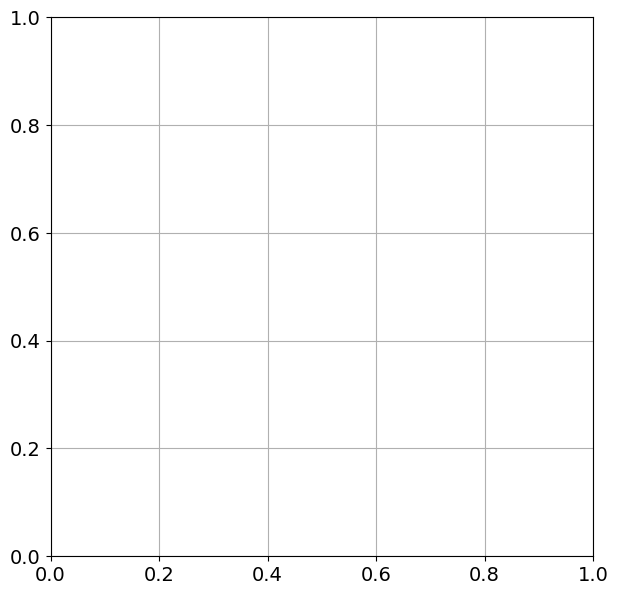

In [63]:
plt.rcParams.update({'font.size': 14})    
plt.figure(figsize=(7,7))
plt.grid(True)
plt.scatter(syn_sizes1, syn_sizes2, s=12, color=colors, alpha=0.9)
plt.title('d >100 um')
plt.xlabel('MF syn size onto pyr 1')
plt.ylabel('MF syn size onto pyr 2')
plt.gca().set_aspect("equal")
#plt.xlim([0,70])
#plt.ylim([0,70])

plt.figure(figsize=(5,5))
plt.hist(d_between_two_syn,20)
plt.xlabel('Distance between two syn (um)')
plt.ylabel('Number of syn pairs')


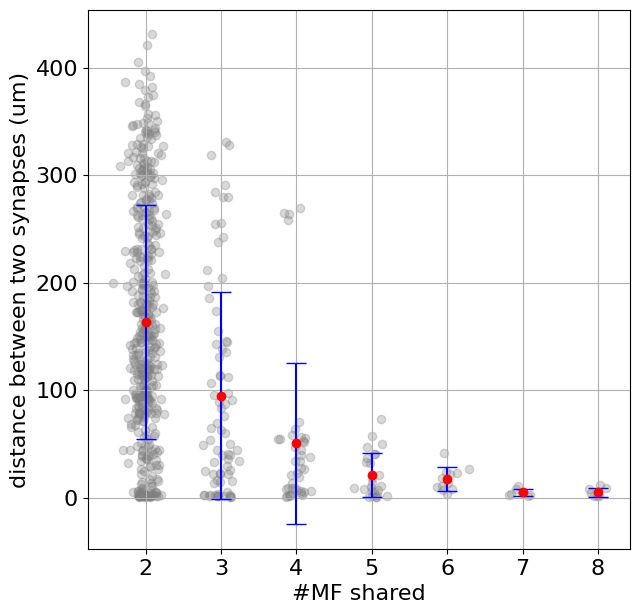

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_98134/4239831352.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='numMF',y='d', data=df, inner=None, width=0.8, palette='pastel')


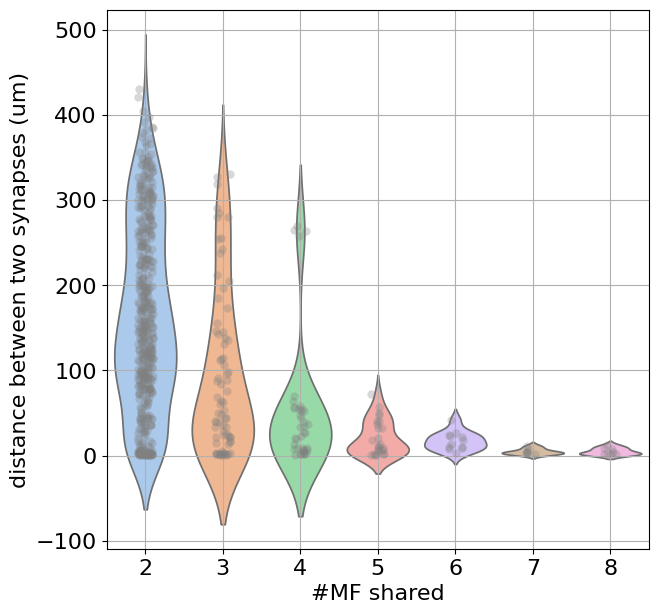

In [21]:
plt.rcParams.update({'font.size': 16})    
plt.figure(figsize=(7,7))
plt.grid(True)
df = pd.DataFrame({'numMF':data_numMF_shared,'d':data_dist_btwn_two_syn})
grouped = df.groupby('numMF')['d'].agg(['mean','std']).reset_index()
x_jittered = df['numMF'] + np.random.normal(0, 0.1, size=len(df))
plt.scatter(x_jittered, df['d'], alpha=0.3, color='gray', label='Individual Points')
plt.errorbar(grouped['numMF'], grouped['mean'], yerr=grouped['std'], ecolor='blue',mfc='red',mec='red',fmt='o', capsize=7)
plt.xlabel("#MF shared")
plt.ylabel('distance between two synapses (um)')
plt.show()

import seaborn as sns
plt.figure(figsize=(7,7))
sns.violinplot(x='numMF',y='d', data=df, inner=None, width=0.8, palette='pastel')
sns.stripplot(x='numMF',y='d', data=df, size=6, jitter=0.1, color='gray',alpha=0.3)
plt.xlabel("#MF shared")
plt.ylabel('distance between two synapses (um)')
plt.grid(True)
plt.show()

In [107]:
# N trials of physically-constrained randomized connectivity
# Shuffle the connections between bouton and thorns within a radius
# Aim for as many one-to-one matches as possible
# Try to minimize the mapping of many boutons onto one thorn


N = 100
r = 50  # um
d_mat_thresh = (d_mat < r).astype(int)
bouton_indices, thorn_indices = np.where(d_mat_thresh == 1)
edges = np.stack((bouton_indices, thorn_indices), axis=1)
edges = edges.astype(np.uint16)
counters = []
indegree_of_pyr4_radius_model = []
indegree_of_pyr_radius_model = []
target_mf_ids = coord_df['pre_ids'].unique()
target_pyr_ids = coord_df['post_ids'].unique()


# the in-degree distribution of the pyr cells with N(shared_MFs) >=4
pyr4_ids = [648518346433300428, 648518346434626934, 648518346434713105, 648518346436851968, 648518346437999934, 648518346438734008, 648518346438927129, 648518346439062690, 648518346439344540, 648518346439733228, 648518346440668261, 648518346440669872, 648518346441508753, 648518346442875183, 648518346443873469, 648518346444888801, 648518346445726403, 648518346447634591, 648518346447635359, 648518346448280423, 648518346452669158]
for i,val in enumerate(pyr4_ids):
    if val not in pc_ids:
        new_id = client.chunkedgraph.suggest_latest_roots(val)
        pyr4_ids[i] = new_id        
idx_pyr4 = []
for i,val in enumerate(target_pyr_ids):
    if val in pyr4_ids:
        idx_pyr4.append(i)


for ii in range(0,N):    
    t0 = time.time()
    if ii % 10 == 0:
        print('trial number: ',ii)
    np.random.seed(ii)
    np.random.shuffle(edges)
    bouton_matched = set()
    thorn_matched = set()
    #bouton_to_thorn = {f"b{i}": [] for i in range(d_mat_thresh.shape[0])}
    bouton_to_thorn = {i: [] for i in range(d_mat_thresh.shape[0])}
    
    for b, t in edges:
        if b not in bouton_matched and t not in thorn_matched:
            bouton_to_thorn[b].append(t)
            bouton_matched.add(b)
            thorn_matched.add(t)
            
    for b, t in edges:
        if b not in bouton_matched:
            bouton_to_thorn[b].append(t)
            bouton_matched.add(b)
    t1=time.time()

    
    thorn_to_bouton = defaultdict(list)
    for k, vals in bouton_to_thorn.items():
        for v in vals:
            thorn_to_bouton[v].append(k)

    # create adj matrix from shuffled bouton-thorn mapping
    adj_mat_rand = np.zeros((len(target_pyr_ids), len(target_mf_ids)), dtype=int)

    mf_to_pyr_randomized = {i: [] for i in range(len(target_mf_ids))}
    for key, val in bouton_to_thorn.items():
        #key = int(key.lstrip('b'))
        #val = int(val[0].lstrip('t'))
        this_mf_id = coord_df['pre_ids'].values[key]
        this_pyr_id = coord_df['post_ids'].values[val]
        idx_mf = np.where(target_mf_ids==this_mf_id)[0][0]
        idx_pyr = np.where(target_pyr_ids==this_pyr_id)[0][0]
        mf_to_pyr_randomized[idx_mf].append(idx_pyr)

    for key, vals in mf_to_pyr_randomized.items():
        for val in vals:
            adj_mat_rand[val,key] = 1
    print('Randomizing adjacency matrix with structural constraint, done!')

    
    pyr4_rows = adj_mat_rand[idx_pyr4,:]
    indegree_of_pyr4_radius_model.append(np.sum(pyr4_rows, axis=1))
    indegree_of_pyr_radius_model.append(np.sum(adj_mat_rand, axis=1))

    # Find all pairs of pyr cells that share at least two common MFs
    pyr_pairs_rand = []
    shared_mfs_rand = []

    for idx_pyr1, idx_pyr2 in combinations(range(len(target_pyr_ids)),2):
        common_mf_indices = np.where((adj_mat_rand[idx_pyr1,:] == 1) & (adj_mat_rand[idx_pyr2,:] == 1))[0]
        common_mfs = []
        if len(common_mf_indices) >= 2:
            for i in range(len(common_mf_indices)):
                common_mfs.append(target_mf_ids[common_mf_indices[i]])
            pyr_pairs_rand.append([target_pyr_ids[idx_pyr1], target_pyr_ids[idx_pyr2]])
            shared_mfs_rand.append(common_mfs)
    
    num_shared_MFs = [len(sublist) for sublist in shared_mfs_rand]
    freq_num_shared_MFs = Counter(num_shared_MFs)
    counters.append(freq_num_shared_MFs)

    print(t1-t0)

trial number:  0
Randomizing adjacency matrix with structural constraint, done!
69.18478107452393
Randomizing adjacency matrix with structural constraint, done!
88.32359290122986
Randomizing adjacency matrix with structural constraint, done!
995.1785461902618
Randomizing adjacency matrix with structural constraint, done!
81.62968611717224
Randomizing adjacency matrix with structural constraint, done!
90.80270385742188
Randomizing adjacency matrix with structural constraint, done!
97.37164306640625
Randomizing adjacency matrix with structural constraint, done!
1941.4047300815582
Randomizing adjacency matrix with structural constraint, done!
181.11476707458496
Randomizing adjacency matrix with structural constraint, done!
85.66499090194702
Randomizing adjacency matrix with structural constraint, done!
84.98698782920837
trial number:  10
Randomizing adjacency matrix with structural constraint, done!
86.51738119125366
Randomizing adjacency matrix with structural constraint, done!
85.035814

Randomizing adjacency matrix with structural constraint, done!
48.52726888656616


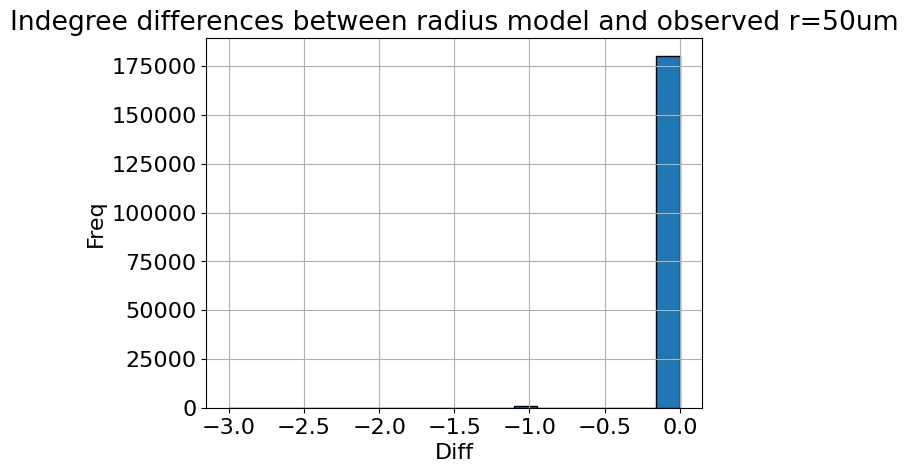

In [108]:
indegree_observed = np.sum(adj_mat, axis=1)
indegree_diff = []
for arr in indegree_of_pyr_config:
    diff = arr - indegree_observed
    indegree_diff.extend(diff)
indegree_diff = np.array(indegree_diff)
plt.hist(indegree_diff, bins='auto', edgecolor='black')
plt.xlabel('Diff')
plt.ylabel('Freq')
plt.title('Indegree differences between radius model and observed r=50um')
plt.grid(True)


In [288]:
# Still under construction
# (faster) N trials of physically-constrained randomized connectivity
# Shuffle the connections between bouton and thorns within a radius
# Aim for as many one-to-one matches as possible
# Try to minimize the mapping of many boutons onto one thorn


N = 1
r = 50  # um
d_mat_thresh = (d_mat < r).astype(int)
bouton_indices, thorn_indices = np.where(d_mat_thresh == 1)


#edges = np.stack((bouton_indices, thorn_indices), axis=1)
#edges = edges.astype(np.uint16)
counters = []
indegree_of_pyr4_radius_model = []
target_mf_ids = coord_df['pre_ids'].unique()
target_pyr_ids = coord_df['post_ids'].unique()


# the in-degree distribution of the pyr cells with N(shared_MFs) >=4
pyr4_ids = [648518346433300428, 648518346434626934, 648518346434713105, 648518346436851968, 648518346437999934, 648518346438734008, 648518346438927129, 648518346439062690, 648518346439344540, 648518346439733228, 648518346440668261, 648518346440669872, 648518346441508753, 648518346442875183, 648518346443873469, 648518346444888801, 648518346445726403, 648518346447634591, 648518346447635359, 648518346448280423, 648518346452669158]
for i,val in enumerate(pyr4_ids):
    if val not in pc_ids:
        new_id = client.chunkedgraph.suggest_latest_roots(val)
        pyr4_ids[i] = new_id        
idx_pyr4 = []
for i,val in enumerate(target_pyr_ids):
    if val in pyr4_ids:
        idx_pyr4.append(i)

for ii in range(0,N):
    t0 = time.time()
    if ii % 10 == 0:
        print('trial number: ',ii)
    
    bouton_matched = set()
    thorn_matched = set()
    #bouton_to_thorn = {f"b{i}": [] for i in range(d_mat_thresh.shape[0])}
    bouton_to_thorn = {i: [] for i in range(d_mat_thresh.shape[0])}
    
    for b in range(np.max(bouton_indices)):
        thorn_candidates = thorn_indices[bouton_indices == b]
        np.random.shuffle(thorn_candidates)
        for jj in range(len(thorn_candidates)):
            t = thorn_candidates[jj]
            if b not in bouton_matched and t not in thorn_matched:
                bouton_to_thorn[b].append(t)
                bouton_matched.add(b)
                thorn_matched.add(t)
                break
    
    bouton_unmatched = [bb for bb in range(np.max(bouton_indices)) if bb not in bouton_matched]
    for b in bouton_unmatched:
        thorn_candidates = thorn_indices[bouton_indices == b]
        np.random.shuffle(thorn_candidates)
        for jj in range(len(thorn_candidates)):
            t = thorn_candidates[jj]
            bouton_to_thorn[b].append(t)
            bouton_matched.add(b)
            thorn_matched.add(t)
            break
                
    t1= time.time()

    thorn_to_bouton = defaultdict(list)
    for k, vals in bouton_to_thorn.items():
        for v in vals:
            thorn_to_bouton[v].append(k)

    # create adj matrix from shuffled bouton-thorn mapping
    adj_mat_rand = np.zeros((len(target_pyr_ids), len(target_mf_ids)), dtype=int)

    mf_to_pyr_randomized = {i: [] for i in range(len(target_mf_ids))}
    for key, val in bouton_to_thorn.items():
        #key = int(key.lstrip('b'))
        #val = int(val[0].lstrip('t'))
        this_mf_id = coord_df['pre_ids'].values[key]
        this_pyr_id = coord_df['post_ids'].values[val]
        idx_mf = np.where(target_mf_ids==this_mf_id)[0][0]
        idx_pyr = np.where(target_pyr_ids==this_pyr_id)[0][0]
        mf_to_pyr_randomized[idx_mf].append(idx_pyr)

    for key, vals in mf_to_pyr_randomized.items():
        for val in vals:
            adj_mat_rand[val,key] = 1
    print('Randomizing adjacency matrix with structural constraint, done!')

    
    pyr4_rows = adj_mat_rand[idx_pyr4,:]
    indegree_of_pyr4_radius_model.append(np.sum(pyr4_rows, axis=1))
    
    # Find all pairs of pyr cells that share at least two common MFs
    pyr_pairs_rand = []
    shared_mfs_rand = []

    for idx_pyr1, idx_pyr2 in combinations(range(len(target_pyr_ids)),2):
        common_mf_indices = np.where((adj_mat_rand[idx_pyr1,:] == 1) & (adj_mat_rand[idx_pyr2,:] == 1))[0]
        common_mfs = []
        if len(common_mf_indices) >= 2:
            for i in range(len(common_mf_indices)):
                common_mfs.append(target_mf_ids[common_mf_indices[i]])
            pyr_pairs_rand.append([target_pyr_ids[idx_pyr1], target_pyr_ids[idx_pyr2]])
            shared_mfs_rand.append(common_mfs)
    
    num_shared_MFs = [len(sublist) for sublist in shared_mfs_rand]
    freq_num_shared_MFs = Counter(num_shared_MFs)
    counters.append(freq_num_shared_MFs)
    print(t1-t0)

trial number:  0


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_92011/3007673613.py:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  idx_pyr = np.where(target_pyr_ids==this_pyr_id)[0][0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [305]:
print(key)
print(np.max(bouton_indices))
print(d_mat.shape)
print(t1-t0)

28725
28725
(28726, 28726)
745.7389540672302


In [97]:
indegree_of_pyr4_radius_model

[array([139,  75, 238, 147, 185,  91, 274, 187, 193,  74, 131,  21, 246,
        155, 230, 205, 169]),
 array([145,  79, 241, 152, 189,  88, 278, 181, 188,  75, 127,  21, 240,
        161, 231, 208, 172]),
 array([137,  79, 238, 146, 197,  87, 271, 178, 192,  74, 123,  20, 247,
        159, 235, 211, 173]),
 array([134,  77, 237, 150, 188,  90, 267, 185, 191,  76, 133,  21, 242,
        162, 232, 208, 170]),
 array([133,  79, 247, 144, 192,  93, 272, 181, 191,  73, 131,  18, 237,
        162, 224, 219, 167]),
 array([135,  79, 245, 144, 195,  89, 277, 179, 190,  74, 131,  19, 242,
        162, 229, 218, 163]),
 array([131,  80, 241, 150, 191,  87, 275, 179, 189,  73, 130,  21, 239,
        162, 229, 214, 163]),
 array([144,  75, 241, 148, 190,  88, 276, 189, 193,  74, 129,  20, 236,
        160, 230, 217, 174]),
 array([133,  76, 242, 140, 187,  88, 270, 179, 194,  73, 130,  21, 239,
        160, 228, 216, 170]),
 array([133,  78, 237, 148, 194,  87, 273, 184, 193,  77, 130,  20, 235,


In [176]:
#lst = np.arange(48568723)
edges = edges.astype(np.uint16)
start = time.time()
np.random.shuffle(edges)
end = time.time()

print("Time to shuffle:", end - start, "seconds")

uint16
Time to shuffle: 27.692450046539307 seconds


In [109]:
# Collect all unique keys
all_keys = set().union(*[counter.keys() for counter in counters])

# Calculate mean and standard deviation
stats = {}
for key in all_keys:
    # Get the values for the key from all counters (default to 0 if key is missing)
    values = [counter.get(key, 0) for counter in counters]
    
    # Compute mean and standard deviation
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # ddof=1 for sample standard deviation
    stats[key] = {"mean": mean, "std_dev": std_dev}

# Display results
print("Stats from " + str(N) + " trials of randomized connectivity with physical constraint of radius " + str(r) + "um")
for key, stat in stats.items():
    print(f"Number of shared MFs: {key}, Mean number of pyr pairs: {stat['mean']:.2f}, Std Dev: {stat['std_dev']:.2f}")

Stats from 100 trials of randomized connectivity with physical constraint of radius 50um
Number of shared MFs: 2, Mean number of pyr pairs: 216.18, Std Dev: 12.27
Number of shared MFs: 3, Mean number of pyr pairs: 18.71, Std Dev: 3.95
Number of shared MFs: 4, Mean number of pyr pairs: 2.98, Std Dev: 1.64
Number of shared MFs: 5, Mean number of pyr pairs: 0.77, Std Dev: 0.85
Number of shared MFs: 6, Mean number of pyr pairs: 0.26, Std Dev: 0.52
Number of shared MFs: 7, Mean number of pyr pairs: 0.03, Std Dev: 0.17


In [101]:
# Degree-preserving randomization using configuration model

n_pyr, n_mf = adj_mat.shape
pyr_deg = adj_mat.sum(axis=1).astype(int).tolist()
mf_deg = adj_mat.sum(axis=0).astype(int).tolist()
counters2 = []
N = 100

indegree_of_pyr4_config = []
indegree_of_pyr_config = []

# the in-degree distribution of the pyr cells with N(shared_MFs) >=4
pyr4_ids = [648518346433300428, 648518346434626934, 648518346434713105, 648518346436851968, 648518346437999934, 648518346438734008, 648518346438927129, 648518346439062690, 648518346439344540, 648518346439733228, 648518346440668261, 648518346440669872, 648518346441508753, 648518346442875183, 648518346443873469, 648518346444888801, 648518346445726403, 648518346447634591, 648518346447635359, 648518346448280423, 648518346452669158]
for i,val in enumerate(pyr4_ids):
    if val not in pc_ids:
        new_id = client.chunkedgraph.suggest_latest_roots(val)
        pyr4_ids[i] = new_id
idx_pyr4 = []
for i,val in enumerate(pc_ids):
    if val in pyr4_ids:
        idx_pyr4.append(i)
print(idx_pyr4)


# randomize matrix
for ii in range(0,N):
    if ii % 10 == 0:
        print('trial number: ',ii)
    B = nx.bipartite.configuration_model(pyr_deg, mf_deg, create_using=nx.Graph(), seed=ii)
    B = nx.Graph(B)
    B.remove_edges_from(nx.selfloop_edges(B))
    n_edges = B.number_of_edges()
    print('Number of deleted edges: ', np.sum(pyr_deg) - n_edges , '/', np.sum(pyr_deg))
    adj_mat_rand_deg_pres = np.zeros((n_pyr, n_mf), dtype=int)
    for u, v in B.edges():
        if u < n_pyr and v >= n_pyr:
            adj_mat_rand_deg_pres[u, v - n_pyr] = 1
        elif v < n_pyr and u >= n_pyr:
            adj_mat_rand_deg_pres[v, u - n_pyr] = 1
            
    pyr4_rows = adj_mat_rand_deg_pres[idx_pyr4,:]
    indegree_of_pyr4_config.append(np.sum(pyr4_rows, axis=1))
    indegree_of_pyr_config.append(np.sum(adj_mat_rand_deg_pres, axis=1))
    print('Finding all pairs of pyr cells...')
    # Find all pairs of pyr cells that share at least two common MFs    
    pyr_pairs_rand = []
    shared_mfs_rand = []
    for idx_pyr1, idx_pyr2 in combinations(range(len(pc_ids)),2):
        common_mf_indices = np.where((adj_mat_rand_deg_pres[idx_pyr1,:] == 1) & (adj_mat_rand_deg_pres[idx_pyr2,:] == 1))[0]
        common_mfs = []
        if len(common_mf_indices) >= 2:
            for i in range(len(common_mf_indices)):
                common_mfs.append(mf_ids[common_mf_indices[i]])
            pyr_pairs_rand.append([pc_ids[idx_pyr1], pc_ids[idx_pyr2]])
            shared_mfs_rand.append(common_mfs)

    num_shared_MFs = [len(sublist) for sublist in shared_mfs_rand]
    freq_num_shared_MFs = Counter(num_shared_MFs)
    counters2.append(freq_num_shared_MFs)

print('done!')

[484, 537, 565, 587, 710, 716, 750, 760, 812, 834, 838, 847, 887, 926, 992, 1030, 1039, 1066, 1087, 1105, 1108]
trial number:  0
Number of deleted edges:  14 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  16 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  13 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  12 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  9 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  13 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  18 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  20 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  14 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  14 / 30416
Finding all pairs of pyr cells...
trial number:  10
Number of deleted edges:  19 / 30416
Finding all pairs of pyr cells...
Number of deleted edges:  12 / 30416
Finding all pairs of pyr cells...
Nu

In [102]:
a1 = np.sum(adj_mat_rand_deg_pres,axis=0)
a2 = np.sum(adj_mat,axis=0)
print(a1[0:20])
print(a2[0:20])

[1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
[1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]


In [103]:
# Get mean and std stats

all_keys = set().union(*[counter.keys() for counter in counters2])
stats = {}
for key in all_keys:
    values = [counter.get(key, 0) for counter in counters2]
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # ddof=1 for sample standard deviation
    stats[key] = {"mean": mean, "std_dev": std_dev}

# Display results
print("Stats from " + str(N) + " trials of configuration model (degree-preserving)")
for key, stat in stats.items():
    print(f"Number of shared MFs: {key}, Mean number of pyr pairs: {stat['mean']:.2f}, Std Dev: {stat['std_dev']:.2f}")

Stats from 100 trials of configuration model (degree-preserving)
Number of shared MFs: 2, Mean number of pyr pairs: 117.89, Std Dev: 8.90
Number of shared MFs: 3, Mean number of pyr pairs: 4.71, Std Dev: 2.58
Number of shared MFs: 4, Mean number of pyr pairs: 0.37, Std Dev: 0.65
Number of shared MFs: 5, Mean number of pyr pairs: 0.03, Std Dev: 0.17


In [151]:
# N trials of edge-swapping random connectivity
from tqdm import tqdm

def shuffle_sparse_matrix(sparse_mat,num_swaps,seed):
    rng = np.random.default_rng(seed)
    mat = sparse_mat.copy().tocoo()
    edge_set = set(zip(mat.col,mat.row))
    edge_list = list(edge_set)
    swaps_done = 0
    max_trials = num_swaps * 5
    
    for _ in tqdm(range(max_trials), desc="Swapping edges"):
        if swaps_done >= num_swaps:
            break
        
        idx1, idx2 = rng.choice(len(edge_list), size=2, replace=False)
        i,j = edge_list[idx1]
        k,l = edge_list[idx2]
        if (i == k or j == l):
            continue  # skip if would create self-loop
        if ((i, l) in edge_set or (k, j) in edge_set):
            continue  # skip if new edges already exist

        # Perform swap: remove (i,j) and (k,l), add (i,l) and (k,j)
        edge_set.remove((i, j))
        edge_set.remove((k, l))
        edge_set.add((i, l))
        edge_set.add((k, j))

        edge_list[idx1] = (i, l)
        edge_list[idx2] = (k, j)
        swaps_done += 1

    final_cols, final_rows = zip(*edge_list)
    shuffled = sp.csr_matrix((np.ones(len(final_rows), dtype=np.uint8), (final_rows, final_cols)), shape=mat.shape)
    return shuffled
    
nswaps= 100000
counters3 = []
N = 100
adj_mat_sparse = sp.csr_matrix(adj_mat)

for ii in range(0,N):
    if ii%10 == 0:
        print('trial number: ',ii)    
    shuffled = shuffle_sparse_matrix(adj_mat_sparse, nswaps, ii)
    
    pyr_pairs_rand = []
    shared_mfs_rand = []
    for idx_pyr1, idx_pyr2 in combinations(range(len(pc_ids)),2):
        row1 = shuffled[idx_pyr1, :].toarray().ravel()
        row2 = shuffled[idx_pyr2, :].toarray().ravel()
        common_mf_indices = np.where((row1 == 1) & (row2 == 1))[0]
        common_mfs = []
        if len(common_mf_indices) >= 2:
            for i in range(len(common_mf_indices)):
                common_mfs.append(mf_ids[common_mf_indices[i]])
            pyr_pairs_rand.append([pc_ids[idx_pyr1], pc_ids[idx_pyr2]])
            shared_mfs_rand.append(common_mfs)

    num_shared_MFs = [len(sublist) for sublist in shared_mfs_rand]
    freq_num_shared_MFs = Counter(num_shared_MFs)
    counters3.append(freq_num_shared_MFs)

trial number:  0


Swapping edges:  20%|██████████████▋                                                          | 100420/500000 [00:00<00:01, 213041.72it/s]


trial number:  10


Swapping edges:  20%|██████████████▋                                                          | 100402/500000 [00:00<00:01, 210318.07it/s]


trial number:  20


Swapping edges:  20%|██████████████▋                                                          | 100452/500000 [00:00<00:01, 200182.56it/s]


trial number:  30


Swapping edges:  20%|██████████████▋                                                          | 100428/500000 [00:00<00:02, 188398.02it/s]


trial number:  40


Swapping edges:  20%|██████████████▋                                                          | 100436/500000 [00:00<00:01, 220220.15it/s]


trial number:  50


Swapping edges:  20%|██████████████▋                                                          | 100431/500000 [00:00<00:01, 202321.95it/s]


trial number:  60


Swapping edges:  20%|██████████████▋                                                          | 100430/500000 [00:00<00:02, 199353.22it/s]


trial number:  70


Swapping edges:  20%|██████████████▋                                                          | 100456/500000 [00:00<00:01, 210596.00it/s]


trial number:  80


Swapping edges:  20%|██████████████▋                                                          | 100458/500000 [00:00<00:01, 205925.71it/s]


trial number:  90


Swapping edges:  20%|██████████████▋                                                          | 100415/500000 [00:00<00:01, 213000.30it/s]


In [152]:
# Get mean and std stats

all_keys = set().union(*[counter.keys() for counter in counters3])
stats = {}
for key in all_keys:
    values = [counter.get(key, 0) for counter in counters3]
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # ddof=1 for sample standard deviation
    stats[key] = {"mean": mean, "std_dev": std_dev}

# Display results
print("Stats from " + str(N) + " trials of edge-swap model (degree-preserving)")
for key, stat in stats.items():
    print(f"Number of shared MFs: {key}, Mean number of pyr pairs: {stat['mean']:.2f}, Std Dev: {stat['std_dev']:.2f}")

Stats from 100 trials of edge-swap model (degree-preserving)
Number of shared MFs: 2, Mean number of pyr pairs: 91.88, Std Dev: 9.42
Number of shared MFs: 3, Mean number of pyr pairs: 3.56, Std Dev: 1.85
Number of shared MFs: 4, Mean number of pyr pairs: 0.25, Std Dev: 0.50


In [ ]:
# Divide the proximodistal curve by distance bins and do piece-wise configuration model

pc_dist_df = {"pc_ids":latest_roots_PC, "curve_dist":mfpc_df['curve_distance'].values}
pc_dist_df_sorted = pc_dist_df.sort_values(by='curve_dist')
pyr_id_to_index = {rid: idx for idx, rid in enumerate(pc_ids)}
new_order = [id_to_index[rid] for rid in pc_dist_df_sorted['pc_ids'].values]
sorted_adjmat = adj_mat[new_order,:]


# Divide the proximodistal curve into bins
bin_size = 200  # um
pc_dist_sorted = np.array(pc_dist_df_sorted['curve_dist'].values)
min_d = pc_dist_sorted[0]
max_d = pc_dist_sorted[-1]
bin_edges = np.arange(min_d, max_d + bin_size, bin_size)

bin_start_indices = np.searchsorted(pc_dist_sorted, bin_edges, side='left')
bin_end_indices = np.searchsorted(pc_dist_sorted, bin_edges, side='right') # Or `np.searchsorted(sorted_numbers, bin_edges + bin_size_epsilon, side='left')`


In [ ]:
# small test case
conn_matrix = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 0, 1]
])

# Original list of row IDs
row_ids = [101, 102, 103]
# Shuffled list of row IDs (new desired order)
shuffled_ids = [103, 101, 102]
# Create a mapping from original row_ids to their indices
id_to_index = {rid: idx for idx, rid in enumerate(row_ids)}
# Get the new row order based on the shuffled_ids
new_order = [id_to_index[rid] for rid in shuffled_ids]
# Apply the row reordering
sorted_matrix = conn_matrix[new_order, :]
print(sorted_matrix)

In [ ]:
# Bouton intervals of MFs shared by a pyr cell pairs 

pyr_pairs_flat = [item for sublist in pyr_pairs for item in sublist]
shared_mfs_flat = [item for sublist in shared_mfs for item in sublist]

syn = client.materialize.synapse_query(pre_ids=shared_mfs_flat, post_ids=pyr_pairs_flat, bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=t195, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 

bouton_intervals = []

for i in range(0, len(pyr_pairs)):
    for j in range(0, len(shared_mfs[i])):
        this_syn1 = syn[(syn['pre_pt_root_id'] == shared_mfs[i][j]) & (syn['post_pt_root_id'] == pyr_pairs[i][0])]
        this_syn2 = syn[(syn['pre_pt_root_id'] == shared_mfs[i][j]) & (syn['post_pt_root_id'] == pyr_pairs[i][1])]  
        bouton1_coord = (np.mean(this_syn1['pre_pt_position'].values, axis=0))
        bouton2_coord = (np.mean(this_syn2['pre_pt_position'].values, axis=0))
        bouton_intervals.append(np.linalg.norm(bouton1_coord - bouton2_coord))


In [ ]:

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 16
bin_width = 2
bins = np.arange(0, max(bouton_intervals) + bin_width, bin_width)
plt.hist(bouton_intervals,bins=bins, alpha=1)
plt.xlabel('Distance (\u00b5m)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Inter-bouton distance of MFs targeting common pyr pairs\n N(bouton_pairs)='+str(len(bouton_intervals)))


In [ ]:
# small test case

matrix = np.random.randint(0, 6, size=(10, 10))
#print(matrix)
d_mat_thresh = (matrix < 3).astype(int)
print(d_mat_thresh)

bouton_indices, thorn_indices = np.where(d_mat_thresh == 1)
edges = [(f"b{i}", f"t{j}") for i, j in zip(bouton_indices, thorn_indices)]
random.shuffle(edges)

bouton_matched = set()
thorn_matched = set()
bouton_to_thorn = {f"b{i}": [] for i in range(d_mat_thresh.shape[0])}
print('matching...')


stime = time.time() 
for b, t in edges:
    if b not in bouton_matched and t not in thorn_matched:
        bouton_to_thorn[b].append(t)
        bouton_matched.add(b)
        thorn_matched.add(t)
        
for b, t in edges:
    if b not in bouton_matched:
        bouton_to_thorn[b].append(t)
        bouton_matched.add(b)
        
print(bouton_to_thorn)